In [14]:
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'machine-learning-ex11'))
	print(os.getcwd())
except:
	pass

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import random
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import UnivariateSpline
import warnings
warnings.filterwarnings('ignore')

#### 1. Изучите классическую работу У. Рурмаира о криптографических атаках с помощью машинного обучения на ФНФ.

#### 2. Сформулируйте задачу в терминах машинного обучения.


Machine learning (ML) algorithm must learn the challenge-response (CR) behavior of the PUF.
 The CR behavior is defined by activities which occur in two disjoint phases of the algorithm;
The Path Sensitization Phase and the Delay Processing Phase.
 The inputs to the Path Sensitization Phase are a set of 2-vector sequences (challenges) and the outputs are a set of n digitized path delays.
 The inputs to the Delay Processing Phase are the n path delays and module parameters, and the output is the response bitstring {-1,1}.
 More specifically, ML must implicitly learn and predict (1) which structural paths will be sensitized under a given set of challenges
 during the Path Sensitization Phase, and (2) what the response bitstring will be for a chip-specific set of n path delays
 and module parameters in the Delay Processing Phase.

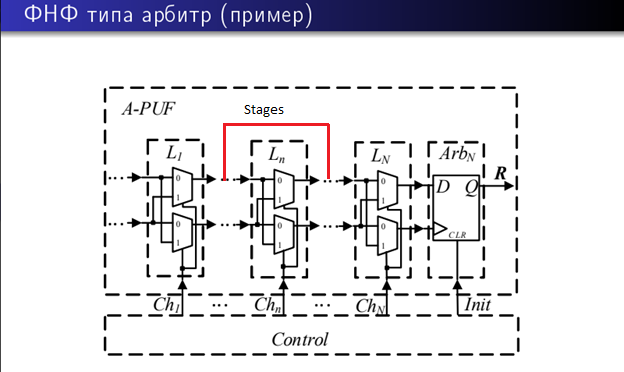

In [16]:
from IPython.display import Image
Image(filename='APUF.png',width=800, height=400)

#### 3. Обучите модель, которая могла бы предсказывать ответы по запросам, которых нет в обучающей выборке.

In [17]:
#Этапы внутри APUF, помеченные на рисунке, со своими задержками

class Stage:
    _delay_out_a = 0.
    _delay_out_b = 0.
    _selector = 0

    def __init__(self,delay_a,delay_b):
        self._delay_out_a = delay_a
        self._delay_out_b = delay_b

    def set_selector(self,s):
        self._selector = s

    def get_output(self,delay_in_a, delay_in_b):
        if self._selector == 0:
            return (delay_in_a  + self._delay_out_a, 
                    delay_in_b  + self._delay_out_b)
        else:
            return (delay_in_b  + self._delay_out_a, 
                    delay_in_a  + self._delay_out_b)

In [18]:
#Непосредственно сам арбитр ФНФ со своими этапами

class ArbiterPUF:

    def __init__(self,n):
        self._stages = []

        for _ in range(n):
            d1 = random.random()
            d2 = random.random()
            self._stages.append(Stage(d1,d2))

    def get_output(self,chall):
        # Set challenge
        for stage,bit in zip(self._stages,chall):
            stage.set_selector(bit)

        # Compute output
        delay = (0,0)
        for s in self._stages:
            delay = s.get_output(delay[0],delay[1])

        if delay[0] < delay[1]:
            return 0
        else:
            return 1

In [19]:
# Transforms a challenge into a feature vector

def into_features_vect(chall):
    phi = []
    for i in range(1,len(chall)):
        s = sum(chall[i:])
        if s % 2 == 0:
            phi.append(1)
        else:
            phi.append(-1)
    phi.append(1)
    return phi

In [35]:
N  = 32     # Size of the PUF
LS = 600    # Size learning set
TS = 10000  # Size testing set
apuf = ArbiterPUF(N)

# Creating training suite
learningX = [[random.choice([0,1]) for _ in range(N)] for _ in range(LS)] # Challenges
learningY = [apuf.get_output(chall) for chall in learningX] # Outputs PUF

# Creating testing suite
testingX = [[random.choice([0,1]) for _ in range(N)] for _ in range(TS)] 
testingY = [apuf.get_output(chall) for chall in testingX]

# Convert challenges into feature vectors
learningX = [into_features_vect(c) for c in learningX]
testingX = [into_features_vect(c) for c in testingX]

# Prediction
lr = LogisticRegression()
lr.fit(learningX, learningY)
print("Score arbiter PUF (%d stages): %f" % (N,lr.score(testingX,testingY)))

Score arbiter PUF (128 stages): 0.954100


#### 4. Применить как минимум 3 различных алгоритма (например, метод опорных векторов, логистическая регрессия и градиентный бустинг).

In [25]:
svc = SVC()
svc.fit(learningX, learningY)
print("Score arbiter PUF (%d stages): %f" % (N, svc.score(testingX, testingY)))

Score arbiter PUF (32 stages): 0.940600


In [24]:
gb = GradientBoostingClassifier()
gb.fit(learningX, learningY)
print("Score arbiter PUF (%d stages): %f" % (N, gb.score(testingX, testingY)))

Score arbiter PUF (32 stages): 0.889000


#### 5. Какая метрика наиболее подходит для оценки качества алгоритма?

Количество правильных ответов обученной модели на тестовом наборе, деленное на количество challenge-response pairs (CRP) в тестовом наборе. 

#### 6. Какой наибольшей доли правильных ответов (Accuracy) удалось достичь?

Самого большой accuracy удалось достичь используя алгоритм линейной регрессии.
Его доля правильных ответов (на 32-битном арбитре) составила 0.97
Для сравнения: SVM = 0.94, GB = 0.88

#### 7. Какой размер обучающей выборки необходим, чтобы достигнуть доли правильных ответов минимум 0.95?

Чтобы достичь 95% доли правильных ответов, необходимо примерно 620 входных значений в случае с 64-битным Арбитром 
и примерно 1240 входных значений в случае с 128-битным Арбитром.


#### 8. Как зависит доля правильных ответов от N?

Доля правильных ответов прямопропорционально зависит от количества входных пар запрос-ответ.

Text(0.5, 0, 'N')

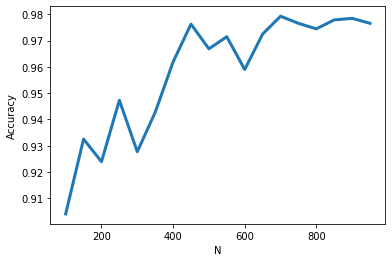

In [36]:
learning_set_numbers = np.arange(100, 1000, 50)
scores = []

for i in learning_set_numbers:
    N  = 32     # Size of the PUF
    LS = i    # Size learning set
    TS = 10000  # Size testing set
    apuf = ArbiterPUF(N)
    
    # Creating training suite
    learningX = [[random.choice([0,1]) for _ in range(N)] for _ in range(LS)] # Challenges
    learningY = [apuf.get_output(chall) for chall in learningX] # Outputs PUF
    
    # Creating testing suite
    testingX = [[random.choice([0,1]) for _ in range(N)] for _ in range(TS)] 
    testingY = [apuf.get_output(chall) for chall in testingX]
    
    # Convert challenges into feature vectors
    learningX = [into_features_vect(c) for c in learningX]
    testingX = [into_features_vect(c) for c in testingX]
    
    # Prediction
    lr = LogisticRegression()
    lr.fit(learningX, learningY)
    scores.append(lr.score(testingX, testingY))

plt.plot(learning_set_numbers, scores, LineWidth=3)
plt.ylabel('Accuracy')
plt.xlabel('N')